# SVR 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import nextbike.preprocessing.Preprocessing as prep

from scipy.stats import zscore
import numpy as np
from vincenty import vincenty 
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.svm import SVR
import time

In [2]:
df = pd.read_csv('../../data/processed/dortmund_trips.csv', index_col=0)

In [3]:
df = df.sample(50000)

In [4]:
X = df[["month","weekday","day_of_year","hour","minute","latitude_start","longitude_start","area_start","temperature °C","precipitation", "distanceToUniversity","distanceToCentralStation"]]
y = df["trip_duration"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

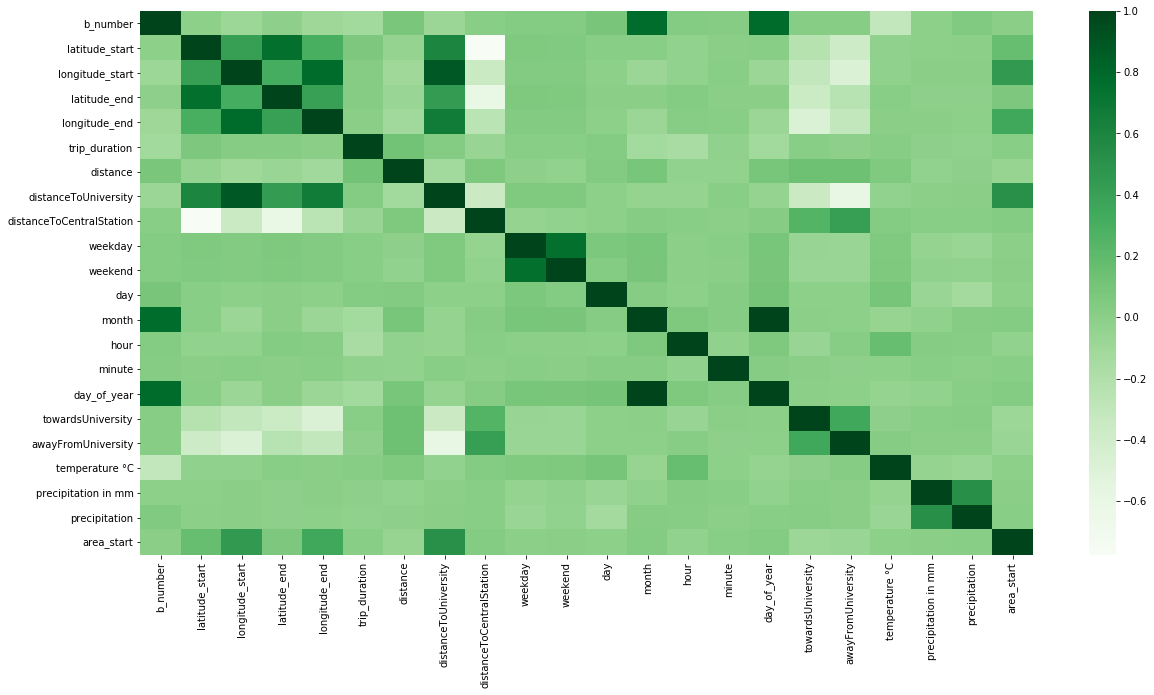

In [5]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),cmap="Greens")

In [6]:
name, r2, rmse, mae, exetime, desc = [],[],[],[],[],[]

In [7]:
def prediction_svr(estimator=SVR()):
    start = time.time()
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    scaler.fit(X_test)
    X_test_scaled = scaler.transform(X_test)

    svr = estimator
    svr.fit(X_train_scaled,y_train)

    y_pred = svr.predict(X_test_scaled)
    y_pred_train = svr.predict(X_train_scaled)
    end = time.time()
    
    print("w/o cross-validaiton:")
    print("R2-Score is: {}".format(r2_score(y_train,y_pred_train)))
    print("RMSE: {}".format(np.sqrt(mean_squared_error(y_train,y_pred_train))))
    print("MAE: {}".format(mean_absolute_error(y_train,y_pred_train)))

    print("")
    print("w/ cross-valiprinton")
    print("R2-Score is: {}".format(r2_score(y_test,y_pred)))
    print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test,y_pred))))
    print("MAE: {}".format(mean_absolute_error(y_test,y_pred)))
    
    name.append("SVR")
    r2.append(r2_score(y_test,y_pred))
    rmse.append(np.sqrt(mean_squared_error(y_test,y_pred)))
    mae.append(mean_absolute_error(y_test,y_pred))
    exetime.append((end-start)/60)
    desc.append(estimator)                    

In [8]:
prediction_svr(SVR())

w/o cross-validaiton:
R2-Score is: -0.07210952441388763
RMSE: 88.12605716206913
MAE: 28.782759118378152

w/ cross-valiprinton
R2-Score is: -0.08007874513006064
RMSE: 87.55023444286917
MAE: 29.55456846974788


In [9]:
prediction_svr(SVR(epsilon=30,C=100,kernel="rbf",gamma="auto"))

w/o cross-validaiton:
R2-Score is: 0.024289813473405086
RMSE: 84.07080042302255
MAE: 39.71554691782424

w/ cross-valiprinton
R2-Score is: 0.019080696346972514
RMSE: 83.43461074257333
MAE: 40.23916793942916


# Parameter Tuning 

In [10]:
# param tuning
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

svr = SVR()
kernel = ["poly","rbf","linar","sigmoid"]
C = [10,20,40,80,150,200]
epsilon =[10,20,30,40,50]
degree = [1,2,3,4]
gamma = ["auto","scale"]
verbose = [True,False]
max_iter = [10,20,30,40,50,100,200,500]

random_grid = {'kernel': kernel,
               'C': C,
               'epsilon': epsilon,
               'gamma': gamma,
               "degree":degree,
               "verbose":verbose,
               "max_iter":max_iter
}

# Random search of parameters
svr_random = RandomizedSearchCV(estimator = svr, param_distributions = random_grid, n_iter = 100,
                                  cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
svr_random.fit(X_train_scaled, y_train)
# print results
print(svr_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   32.7s finished


[LibSVM]{'verbose': True, 'max_iter': 500, 'kernel': 'poly', 'gamma': 'auto', 'epsilon': 30, 'degree': 1, 'C': 40}


In [11]:
prediction_svr(SVR(kernel="poly",C=40,epsilon=30,degree=1, gamma="auto", verbose=True,max_iter=500))

[LibSVM]w/o cross-validaiton:
R2-Score is: -0.4285207146047223
RMSE: 101.72507855622989
MAE: 72.02160738100216

w/ cross-valiprinton
R2-Score is: -0.4202385875417147
RMSE: 100.39457778511455
MAE: 71.81632565328135


In [12]:
pd.set_option("display.max_colwidth",-1)

results = {
    "Name":name, 
    "R2": r2, 
    "RMSE":rmse,
    "MAE":mae, 
    "Execution time (min)": exetime, 
    "Description":desc
}

df_results = pd.DataFrame(results)
df_results

,Name,R2,RMSE,MAE,Execution time (min),Description
0,SVR,-0.080079,87.550234,29.554568,1.579823,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',\n kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)"
1,SVR,0.019081,83.434611,40.239168,0.689221,"SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=30, gamma='auto',\n kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)"
2,SVR,-0.420239,100.394578,71.816326,0.027797,"SVR(C=40, cache_size=200, coef0=0.0, degree=1, epsilon=30, gamma='auto',\n kernel='poly', max_iter=500, shrinking=True, tol=0.001, verbose=True)"
